In [2]:
from itertools import combinations
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from pandarallel import pandarallel
pandarallel.initialize()
import seaborn as sns

from scipy.stats import pearsonr, linregress


INFO: Pandarallel will run on 48 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Philipps data

In [3]:
df_list=[]
for i in tqdm(range(66)):
    df=pd.read_pickle(f"/home/athenes/Paraplume/data_with_scripts/repertoire_analysis/philipps/splits/paratope_9114_sequences_{i}.pkl")
    df_list.append(df)
total_df = pd.concat(df_list)

  0%|          | 0/66 [00:00<?, ?it/s]

100%|██████████| 66/66 [00:52<00:00,  1.26it/s]


In [4]:

mutation_columns = [
    'mutation_1', 'mutation_2', 'mutation_3', 'mutation_4', 'mutation_5',
    'mutation_6', 'mutation_7', 'mutation_8', 'mutation_9', 'mutation_10',
    'mutation_11', 'mutation_12', 'mutation_13', 'mutation_14',
    'mutation_15', 'mutation_16'
]
total_df[mutation_columns]=total_df[mutation_columns].astype(int)
total_df["mutations"] = total_df[mutation_columns].astype(str).agg("".join, axis=1)
total_df["total_mutations"]=total_df["mutations"].apply(lambda x:np.sum([int(char) for char in list(x)]))
total_df["paratope_size"]=total_df["model_prediction_heavy"].apply(lambda x:np.sum(x))+total_df["model_prediction_light"].apply(lambda x:np.sum(x))
total_df["binder H1"]=(total_df["H1_log10Kd"] <-7).astype(int)
total_df["binder H3"]=(total_df["H3_log10Kd"] <-6).astype(int)
total_df["binder FluB"]=(total_df["FluB_log10Kd"] <-6).astype(int)
total_df["mutations_vector"]=total_df["mutations"].apply(lambda x:[int(char) for char in x])


In [5]:
df_flub_binder = total_df.query("FluB_log10Kd<-6")
df_h1_binder = total_df.query("H1_log10Kd<-7")
df_h3_binder = total_df.query("H3_log10Kd<-6")

In [6]:
df_h1_control = total_df.query("H1_log10Kd==-7")


In [7]:
def process_combinations(differing_positions, mutation_dict, pred_1, pred_2,kd1,kd2, n, proba_dict, mode):
    for combo in combinations(differing_positions, n):
        muts = tuple(mutation_dict[pos] for pos in combo)
        if muts not in proba_dict:
            proba_dict[muts] = []
        if mode=="square":
            diff = sum((pred_1[mut] - pred_2[mut])**2 for mut in muts)
            fluB_log10Kd_diff_squared = (kd1 - kd2)**2
        elif mode=="abs":
            diff = sum([np.abs(pred_1[mut] - pred_2[mut]) for mut in muts])
            fluB_log10Kd_diff_squared = np.abs(kd1 - kd2)
        elif mode=="size":
            diff = np.abs(np.sum(pred_1)-np.sum(pred_2))
            fluB_log10Kd_diff_squared = np.abs(kd1 - kd2)
        proba_dict[muts].append([diff, fluB_log10Kd_diff_squared, ])

    return proba_dict

def get_proba_dict(sampled_df, strain, n, mode="square"):
    binary_vectors = np.array(sampled_df["mutations_vector"].tolist())
    hamming_distances = np.sum(np.abs(binary_vectors[:, None, :] - binary_vectors[None, :, :]), axis=2)
    pairs = np.argwhere(np.triu(hamming_distances, k=1) == n)

    df_1 = sampled_df.iloc[pairs[:, 0]].reset_index(drop=True)
    df_2 = sampled_df.iloc[pairs[:, 1]].reset_index(drop=True)

    df_1.reset_index(drop=True, inplace=True)
    df_2.reset_index(drop=True, inplace=True)
    df_1 = df_1.dropna(subset=["Unnamed: 0.2", "Unnamed: 0.1", "Unnamed: 0"])
    df_2 = df_2.dropna(subset=["Unnamed: 0.2", "Unnamed: 0.1", "Unnamed: 0"])

    mutation_dict = {0:28, 1:29, 2:30, 3:51, 4:56, 5:57, 6:58, 7:70, 8:73, 9:74, 10:75, 11:76, 12:83, 13:86, 14:94, 15:105}
    proba_dict = {}

    for i in tqdm(range(len(df_1))):

        vector_1 = np.array(df_1.iloc[i]["mutations_vector"])
        vector_2 = np.array(df_2.iloc[i]["mutations_vector"])
        differing_positions = np.where(vector_1 != vector_2)[0]

        pred_1 = df_1.iloc[i]["model_prediction_heavy"]
        pred_2 = df_2.iloc[i]["model_prediction_heavy"]

        kd1 = df_1.iloc[i][f"{strain}_log10Kd"]
        kd2 = df_2.iloc[i][f"{strain}_log10Kd"]
        proba_dict = process_combinations(differing_positions, mutation_dict, pred_1, pred_2, kd1, kd2, n, proba_dict, mode=mode)
    return proba_dict


In [8]:
seed = 1
np.random.seed(seed)

sampled_df_h1 = df_h1_binder.dropna().sample(n=10000, random_state=seed).reset_index()
sampled_df_h3 = df_h3_binder.dropna().reset_index()
sampled_df_flub = df_flub_binder.dropna().reset_index()


In [26]:
plt.rcParams.update({
    "axes.titlesize": 32,
    "axes.labelsize": 28,
    "xtick.labelsize": 28,
    "ytick.labelsize": 28,
    "legend.fontsize": 30,
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
})


100%|██████████| 373/373 [00:00<00:00, 3935.19it/s]


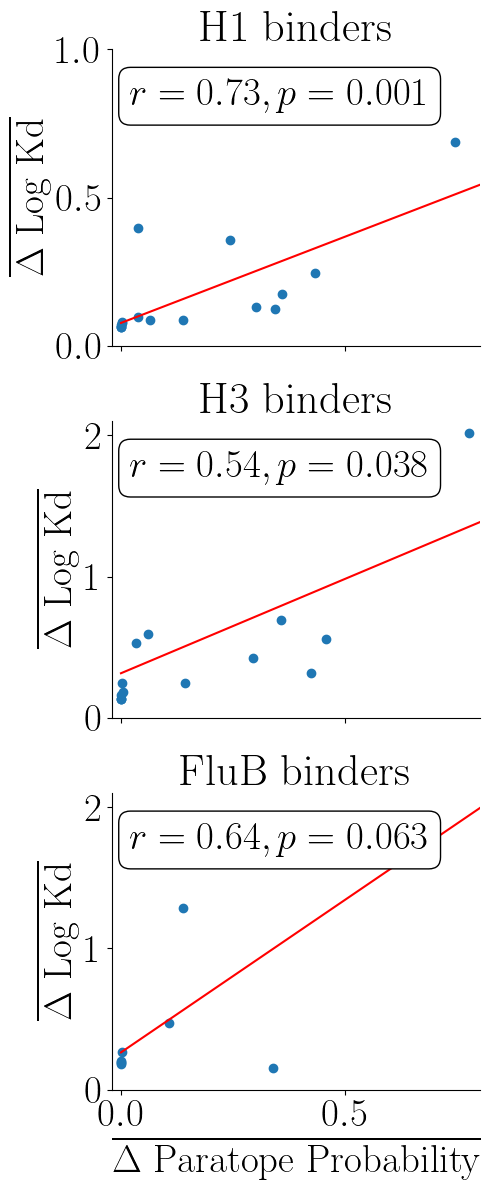

In [10]:

strains = ["H1", "H3", "FluB"]
dfs = [sampled_df_h1, sampled_df_h3, sampled_df_flub]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 12), sharex=True)  # 3 rows, shared x-axis

for ax, strain, df in zip(axes, strains, dfs):
    proba_dict = get_proba_dict(df, strain=strain, n=1, mode="abs")
    xs = [np.mean([each[0] for each in proba_dict[i]]) for i in proba_dict.keys()]
    ys = [np.mean([each[1] for each in proba_dict[i]]) for i in proba_dict.keys()]
    xs = np.array(xs)
    ys = np.array(ys)

    ax.scatter(xs, ys)
    ax.spines['top'].set_visible(False)  # Remove top border
    ax.spines['right'].set_visible(False)  # Remove right border

    corr, p_value = pearsonr(xs, ys)
    slope, intercept, _, _, _ = linregress(xs, ys)
    common_xs = np.linspace(0,1,1000)
    regression_line = slope * common_xs + intercept
    ax.plot(common_xs, regression_line, color='red')

    # Determine p-value format
    if p_value < 0.001:
        exponent = np.ceil(np.log10(p_value)).astype(int)
        p_display = f"p = 10^{{{exponent}}}"
    else:
        p_display = f"p = {p_value:.3f}"

    # Annotate each subplot with correlation & p-value
    ax.annotate(rf"$r={corr:.2f}, {p_display}$", xy=(0.05, 0.9), xycoords='axes fraction',
                ha='left', va='top',
                bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

    ax.set_ylabel(r'$\overline{\Delta \ \mathrm{Log\ Kd}}$')  # Keep y-label for all

    ax.set_title(rf"{strain} binders")
    ax.set_ylim([0,2.1])
    ax.set_xlim([-0.02,0.8])

# Only keep x-label on the bottom plot
axes[0].set_ylim([0,1])
axes[0].set_yticks([0, 0.5, 1])  # Set x-ticks for the first subplot
axes[1].set_yticks([0, 1, 2])  # Set x-ticks for the first subplot
axes[2].set_yticks([0, 1, 2])  # Set x-ticks for the first subplot

axes[-1].set_xlabel(r'$\overline{\Delta \ \mathrm{Paratope\ Probability}}$')

plt.tight_layout()
plt.savefig("/home/athenes/Paraplume/data_with_scripts/plots/figure4A.png", bbox_inches="tight")
plt.show()

/tmp/ipykernel_3381197/1922978690.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h1_control["strain"] = "Non"
/tmp/ipykernel_3381197/1922978690.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h1_binder["strain"] = "H1"
/tmp/ipykernel_3381197/1922978690.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

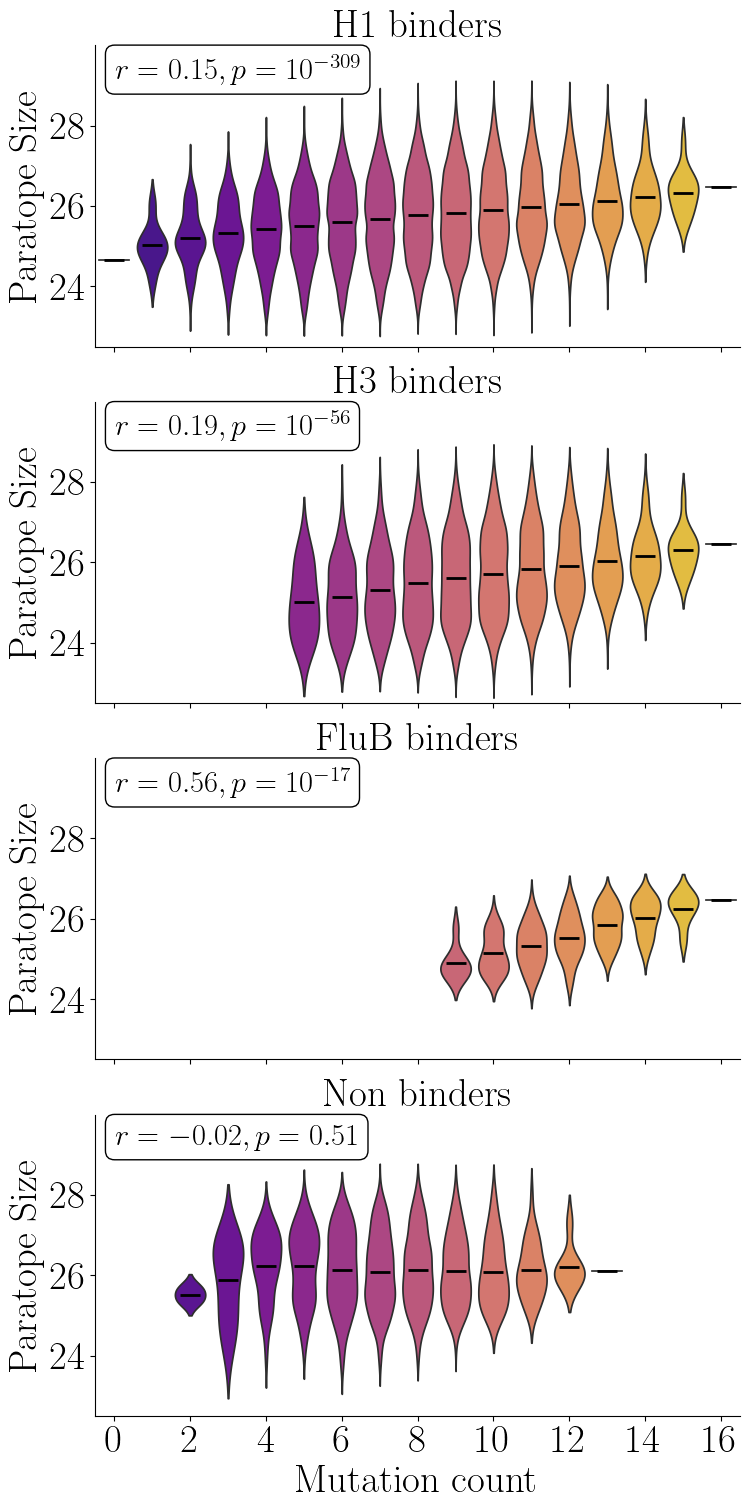

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# Add a 'strain' column to each DataFrame
df_h1_control["strain"] = "Non"
df_h1_binder["strain"] = "H1"
df_h3_binder["strain"] = "H3"
df_flub_binder["strain"] = "FluB"

# Combine the DataFrames
df_combined = pd.concat([df_h1_binder, df_h3_binder, df_flub_binder, df_h1_control])

# Ensure "total_mutations" is treated as a categorical variable
df_combined["total_mutations"] = df_combined["total_mutations"].astype(str)

# Get unique sorted values of "total_mutations"
sorted_mutations = sorted(df_combined["total_mutations"].unique(), key=lambda x: int(x))

# Generate a color palette using a purple-to-yellow gradient
colors = sns.color_palette("plasma", n_colors=len(sorted_mutations))

# Create a color mapping dictionary
color_dict = {mutation: color for mutation, color in zip(sorted_mutations, colors)}

# Create a FacetGrid with a row for each strain
g = sns.FacetGrid(df_combined, row="strain", height=3.8, aspect=2, sharey=True)

# Map the violin plot to the FacetGrid
g.map_dataframe(sns.violinplot,
                x="total_mutations",
                y="paratope_size",
                palette=color_dict,
                inner=None,
                order=sorted_mutations)

# Overlay the mean points in black
for ax, strain in zip(g.axes.flat, df_combined["strain"].unique()):
    subset = df_combined[df_combined["strain"] == strain]
    means = subset.groupby("total_mutations")["paratope_size"].mean()
    sns.pointplot(
        x=means.index,
        y=means.values,
        color="black",
        ax=ax,
        linestyle="none",
        errorbar=None,
        marker="_",
        markersize=15
    )

# Customize plot aesthetics
g.set_titles("{row_name} binders")
g.set_axis_labels("Mutation count", "Paratope Size")

# Add x-tick labels for the last row
for ax in g.axes[-1, :]:
    ticks = ax.get_xticks()
    ax.set_xticks([t for t in ticks if t % 2 == 0])
    ax.set_xticklabels([str(int(t)) for t in ax.get_xticks()])
ax.set_yticks([24, 26, 28])
# Set y-axis limits for all subplots
for ax in g.axes.flat:
    ax.set_ylim(22.5, 30)

# Compute Pearson correlation coefficient and p-value for each row
for ax, strain in zip(g.axes.flat, df_combined["strain"].unique()):
    subset = df_combined[df_combined["strain"] == strain]
    correlation, p_value = pearsonr(subset["total_mutations"].astype(float), subset["paratope_size"])

    # Determine p-value display format
    if p_value < 0.01:
        exponent = np.ceil(np.log10(p_value)).astype(int)
        p_display = f"p = 10^{{{exponent}}}"
    else:
        p_display = f"p = {p_value:.2f}"

    ax.annotate(rf"$r={correlation:.2f}, {p_display}$", xy=(0.03, 0.97), xycoords='axes fraction',
                ha='left', va='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='none'))

# Show plot
plt.tight_layout()
plt.savefig("/home/athenes/Paraplume/data_with_scripts/plots/figure4B.png", bbox_inches="tight")
plt.show()


# Naive vs HiFiBi0 mice

In [12]:
def calculate_mutations(row):
    heavy_mutations = np.sum([row["germline_heavy"][i]!=row["sequence_heavy"][i] for i in range(min(len(row["sequence_heavy"]), len(row["germline_heavy"])))])
    light_mutations = np.sum([row["germline_light"][i]!=row["sequence_light"][i] for i in range(min(len(row["sequence_light"]), len(row["germline_light"])))])
    return heavy_mutations + light_mutations

In [13]:
immunized_sequences = pd.read_pickle("/home/athenes/Paraplume/data_with_scripts/repertoire_analysis/hifibio&naive_mice/paratope_tt_sequences.pkl")
immunized_germlines = pd.read_pickle("/home/athenes/Paraplume/data_with_scripts/repertoire_analysis/hifibio&naive_mice/paratope_tt_germline.pkl")
naive_sequences = pd.read_pickle("/home/athenes/Paraplume/data_with_scripts/repertoire_analysis/hifibio&naive_mice/paratope_naive_sequences.pkl")
naive_germlines = pd.read_pickle("/home/athenes/Paraplume/data_with_scripts/repertoire_analysis/hifibio&naive_mice/paratope_naive_germline.pkl")

In [14]:
immunized_sequences["paratope_size"]=immunized_sequences["model_prediction_heavy"].apply(lambda x:np.sum(x))+immunized_sequences["model_prediction_light"].apply(lambda x:np.sum(x))
immunized_sequences["normalized_paratope_size"]=immunized_sequences["paratope_size"]/(immunized_sequences.sequence_heavy.str.len()+immunized_sequences.sequence_light.str.len())
naive_sequences["paratope_size"]=naive_sequences["model_prediction_heavy"].apply(lambda x:np.sum(x))+naive_sequences["model_prediction_light"].apply(lambda x:np.sum(x))
naive_sequences["normalized_paratope_size"]=naive_sequences["paratope_size"]/(naive_sequences.sequence_heavy.str.len()+naive_sequences.sequence_light.str.len())
naive_sequences["paratope_size"]=naive_sequences["model_prediction_heavy"].apply(lambda x:np.sum(x))+naive_sequences["model_prediction_light"].apply(lambda x:np.sum(x))
naive_sequences["normalized_paratope_size"]=naive_sequences["paratope_size"]/(naive_sequences.sequence_heavy.str.len()+naive_sequences.sequence_light.str.len())
naive_germlines["paratope_size"]=naive_germlines["model_prediction_heavy"].apply(lambda x:np.sum(x))+naive_germlines["model_prediction_light"].apply(lambda x:np.sum(x))
naive_germlines["normalized_paratope_size"]=naive_germlines["paratope_size"]/(naive_germlines.sequence_heavy.str.len()+naive_germlines.sequence_light.str.len())
immunized_sequences["paratope_size"]=immunized_sequences["model_prediction_heavy"].apply(lambda x:np.sum(x))+immunized_sequences["model_prediction_light"].apply(lambda x:np.sum(x))
immunized_sequences["normalized_paratope_size"]=immunized_sequences["paratope_size"]/(immunized_sequences.sequence_heavy.str.len()+immunized_sequences.sequence_light.str.len())
immunized_germlines["paratope_size"]=immunized_germlines["model_prediction_heavy"].apply(lambda x:np.sum(x))+immunized_germlines["model_prediction_light"].apply(lambda x:np.sum(x))
immunized_germlines["normalized_paratope_size"]=immunized_germlines["paratope_size"]/(immunized_germlines.sequence_heavy.str.len()+immunized_germlines.sequence_light.str.len())
immunized_sequences["germline_heavy"]=immunized_germlines["sequence_heavy"]
immunized_sequences["germline_light"]=immunized_germlines["sequence_light"]
naive_sequences["germline_heavy"]=naive_germlines["sequence_heavy"]
naive_sequences["germline_light"]=naive_germlines["sequence_light"]
immunized_sequences["mutation_count"]=immunized_sequences.apply(calculate_mutations, axis=1)
naive_sequences["mutation_count"]=naive_sequences.apply(calculate_mutations, axis=1)
immunized_sequences["clone_size"] = immunized_sequences.groupby("family")["family"].transform("count")
naive_sequences["clone_size"] = naive_sequences.groupby("family")["family"].transform("count")


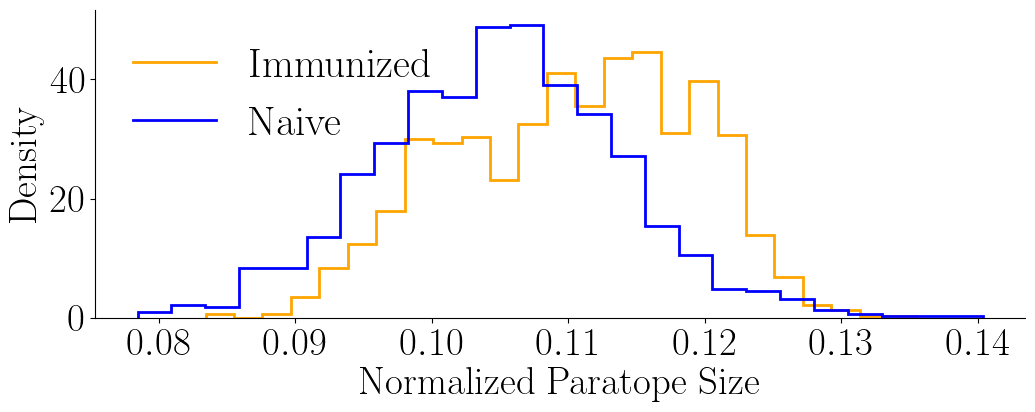

In [15]:
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(12, 4))

# Plot histograms
bins = 25
ax.hist(immunized_sequences["normalized_paratope_size"], bins=bins, density=True, histtype='step', linewidth=2, color='orange', label='Immunized')
ax.hist(naive_sequences["normalized_paratope_size"], bins=bins, density=True, histtype='step', linewidth=2, color='blue', label='Naive')
ax.spines['top'].set_visible(False)  # Remove top border
ax.spines['right'].set_visible(False)  # Remove right border
# Set labels
ax.set_xlabel(r"Normalized Paratope Size")
ax.set_ylabel(r"Density")

# Set legend
legend_lines = [
    Line2D([0], [0], color="orange", lw=2, label="Immunized"),
    Line2D([0], [0], color="blue", lw=2, label="Naive"),
]

ax.legend(handles=legend_lines, loc='upper left', bbox_to_anchor=(0.0, 1), frameon=False)
# Save with higher resolution
plt.savefig("/home/athenes/Paraplume/data_with_scripts/plots/figure4C.png", bbox_inches='tight', dpi=100)


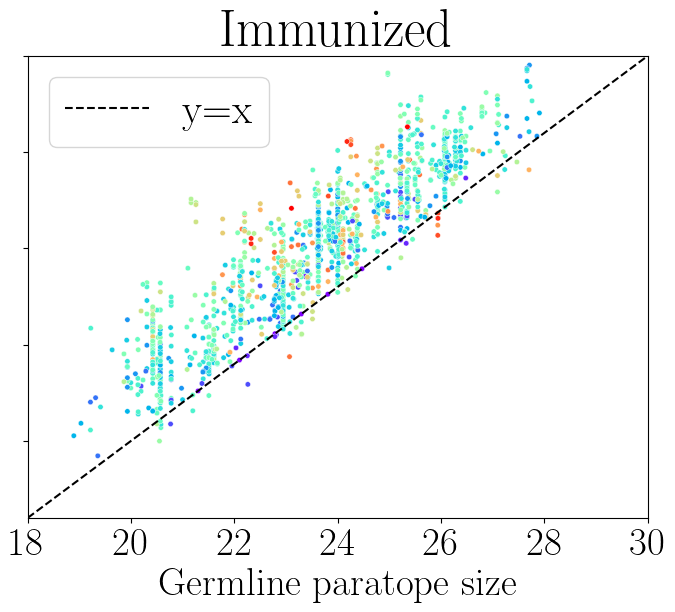

In [ ]:
y = immunized_sequences.query("mutation_count<21")["paratope_size"].tolist()
immunized_germlines["mutation_count"] = immunized_sequences["mutation_count"]
x = immunized_germlines.query("mutation_count<21")["paratope_size"].tolist()
c = immunized_sequences.query("mutation_count<21")["mutation_count"]

# Main figure
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plot
scatter = sns.scatterplot(
    x=x,
    y=y,
    hue=c,
    palette="rainbow",
    s=15,
    ax=ax,
    legend=False
)

# Plot y = x line
x_range = list(range(18, 31, 1))
ax.plot(x_range, x_range, color="black", linestyle="--", label="y=x")

# Labels and limits
ax.set_xlim([18, 30])
ax.set_ylim([18, 30])
ax.set_title(r"Immunized")

ax.legend(loc="upper left")
ax.set_xlabel(r"Germline paratope size")
ax.set_yticklabels([])
ticks = np.arange(18, 31, 2)  # Generate ticks from 18 to 32 with step 2
ax.set_xticks(ticks)
plt.savefig("/home/athenes/Paraplume/data_with_scripts/plots/figure4Dr.png", bbox_inches='tight')


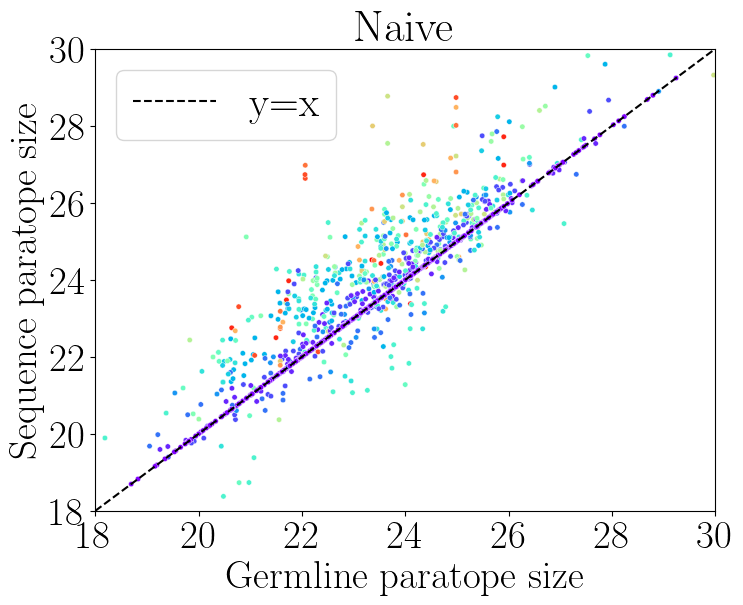

In [17]:
# Assuming naive_sequences and naive_germlines are defined DataFrames
y = naive_sequences.query("mutation_count<21")["paratope_size"].tolist()
naive_germlines["mutation_count"] = naive_sequences["mutation_count"]
x = naive_germlines.query("mutation_count<21")["paratope_size"].tolist()
c = naive_sequences.query("mutation_count<21")["mutation_count"]

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Use make_axes_locatable to create space for colorbar


# Scatter plot
scatter = sns.scatterplot(
    x=x,
    y=y,
    hue=c,
    palette="rainbow",
    s=15,
    ax=ax,
    legend=False
)


# Plot y = x line
x_range=list(range(18,31,1))
ax.plot(x_range, x_range, color="black", linestyle="--", label="y=x")
# Labels
ax.set_xlabel(r"Germline paratope size")
ax.set_ylabel(r"Sequence paratope size")

# Set x and y limits
ax.set_title(r"Naive")
ax.set_xlim([18, 30])
ax.set_ylim([18, 30])

# Set x and y ticks explicitly
ticks = np.arange(18, 31, 2)  # Generate ticks from 18 to 32 with step 2
ax.set_xticks(ticks)
ax.set_yticks(ticks)


# Show legend
ax.legend(loc="upper left")
plt.savefig("/home/athenes/Paraplume/data_with_scripts/plots/figure4Dl.png", bbox_inches='tight')


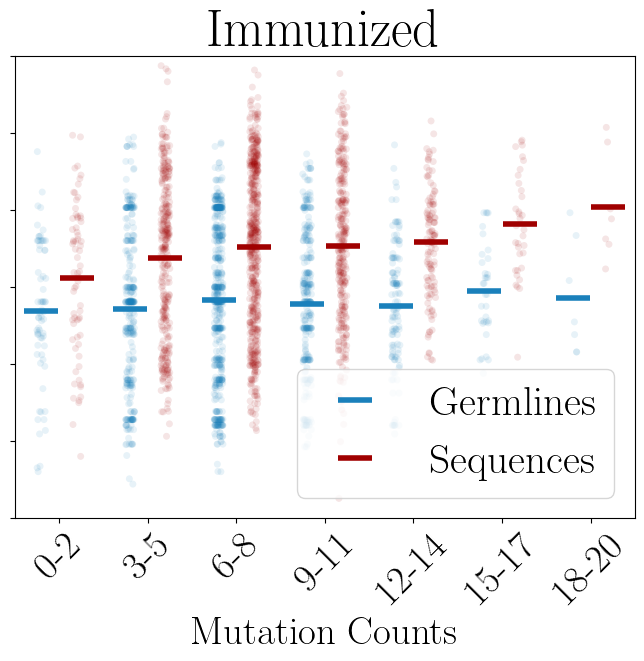

In [ ]:
def plot_mut(mutation_count_germlines, paratope_size_germlines, mutation_count_sequences, paratope_size_sequences, save_name=None, right=False, title=""):
    """
    Plots a strip plot with overlayed mean markers showing paratope size distribution for bins of mutation counts of size 2.
    The left side represents 'immunized_germlines' and the right side represents 'immunized_sequences'.

    Parameters:
    - mutation_count_germlines: List or array of mutation counts for germlines.
    - paratope_size_germlines: List or array of corresponding paratope sizes for germlines.
    - mutation_count_sequences: List or array of mutation counts for sequences.
    - paratope_size_sequences: List or array of corresponding paratope sizes for sequences.
    - save_name: (Optional) If provided, saves the plot to the given filename.
    """
    # Create DataFrames for both datasets
    df_germlines = pd.DataFrame({"Mutation Count": mutation_count_germlines, "Paratope Size": paratope_size_germlines, "Type": r"Germlines"})
    df_sequences = pd.DataFrame({"Mutation Count": mutation_count_sequences, "Paratope Size": paratope_size_sequences, "Type": r"Sequences"})

    # Concatenate the data
    df = pd.concat([df_germlines, df_sequences], ignore_index=True)

    # Define bins of size 2
    bins = range(0, int(df["Mutation Count"].max()) + 3, 3)
    bin_labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins) - 1)]
    df["Mutation Bin"] = pd.cut(df["Mutation Count"], bins=bins, labels=bin_labels, right=True)

    # Convert to categorical with a specific order
    df["Mutation Bin"] = pd.Categorical(df["Mutation Bin"], categories=bin_labels, ordered=True)

    # Strip plot
    plt.figure(figsize=(8, 6))
    sns.stripplot(x="Mutation Bin", y="Paratope Size", hue="Type", data=df, dodge=True, alpha=0.1, legend=False,palette={"Germlines": "#1a80bb", "Sequences": "#a00000"})
    sns.pointplot(x="Mutation Bin", y="Paratope Size", hue="Type", data=df, dodge=0.4, linestyle="none", errorbar=None, marker="_", markersize=25, markeredgewidth=4,     palette={"Germlines": "#1a80bb", "Sequences": "#a00000"}
)
    if right:
        plt.yticks([18,20,22,24,26,28,30],[])
    else:
        plt.yticks([18,20,22,24,26,28,30])
    plt.xlabel(r"Mutation Counts")
    if right:
        plt.ylabel("")
    else:
        plt.ylabel(r"Paratope Size")
    plt.xticks(rotation=45)
    plt.legend(loc="lower right")
    plt.title(rf"{title}", fontsize=38)

    plt.savefig(f"/home/athenes/Paraplume/data_with_scripts/plots/{save_name}.png", bbox_inches="tight")
    plt.ylim([18,30])
    plt.show()

# Process data and call plot_mut
names = ["sequences", "germlines"]
mutation_count_sequences, paratope_size_sequences = [], []
mutation_count_germlines, paratope_size_germlines = [], []

data_dict = {"sequences": (mutation_count_sequences, paratope_size_sequences), "germlines": (mutation_count_germlines, paratope_size_germlines)}

for name, df in zip(names, [immunized_sequences, immunized_germlines]):
    mutation_count_list, paratope_size_list = data_dict[name]
    filtered_df = df.query("mutation_count < 21")[["model_prediction_heavy", "model_prediction_light", "mutation_count"]]
    for h, l, mut in filtered_df.values:
        paratope_size_list.append(np.sum(h) + np.sum(l))
        mutation_count_list.append(mut)

plot_mut(mutation_count_germlines, paratope_size_germlines, mutation_count_sequences, paratope_size_sequences, save_name="figure4Er", right=True, title="Immunized")

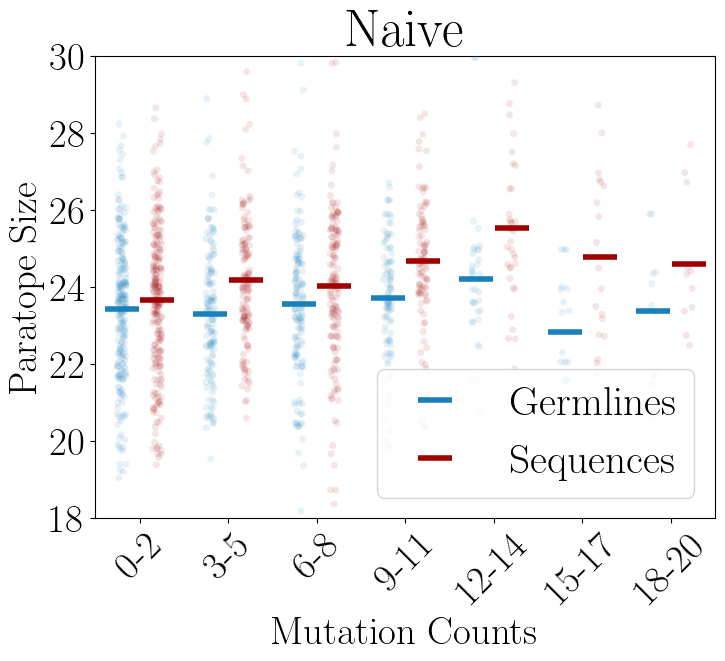

In [19]:
# Process data and call plot_mut
names = ["sequences", "germlines"]
mutation_count_sequences, paratope_size_sequences = [], []
mutation_count_germlines, paratope_size_germlines = [], []

data_dict = {"sequences": (mutation_count_sequences, paratope_size_sequences), "germlines": (mutation_count_germlines, paratope_size_germlines)}

for name, df in zip(names, [naive_sequences, naive_germlines]):
    mutation_count_list, paratope_size_list = data_dict[name]
    filtered_df = df.query("mutation_count < 21")[["model_prediction_heavy", "model_prediction_light", "mutation_count"]]
    for h, l, mut in filtered_df.values:
        paratope_size_list.append(np.sum(h) + np.sum(l))
        mutation_count_list.append(mut)

plot_mut(mutation_count_germlines, paratope_size_germlines, mutation_count_sequences, paratope_size_sequences, save_name="figure4El", right=False, title="Naive")

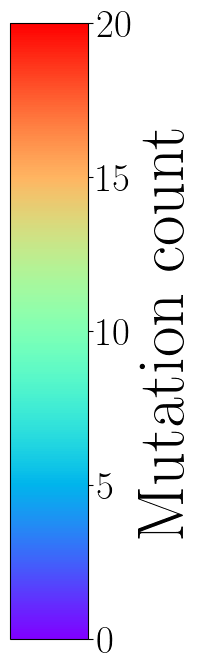

In [20]:
# Separate figure for the colorbar
fig_cbar, ax_cbar = plt.subplots(figsize=(1, 8))
norm = plt.Normalize(vmin=min(c), vmax=max(c))
sm = plt.cm.ScalarMappable(cmap="rainbow", norm=norm)
sm.set_array([])
cbar = fig_cbar.colorbar(sm, cax=ax_cbar)
cbar.set_label(r"Mutation count", fontsize=48)

# Save the colorbar figure
plt.savefig("/home/athenes/Paraplume/data_with_scripts/plots/colorbar.png", bbox_inches='tight')